In [1]:
# 데이터 시각화 및 비만 예측 모델 개발

import pandas as pd

# CSV 불러오기
df = pd.read_csv("./data/health_2023_cleaned_final.csv")

cols_to_float = [
    '식전혈당(공복혈당)', '수축기혈압', '이완기혈압',
    '총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤',
    '혈청지오티(AST)', '혈청지피티(ALT)', '감마지티피',
    '혈청크레아티닌', '요단백',
    '신장(5cm단위)', '체중(5kg단위)', '허리둘레'
]

for col in cols_to_float:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# BMI 계산 (체중 kg / (신장 m)^2)
df['BMI'] = (df['체중(5kg단위)'] * 1.0) / ((df['신장(5cm단위)'] / 100) ** 2)

# --------- [1. 당뇨병 의심] ---------
df['당뇨병의심'] = df['식전혈당(공복혈당)'].apply(lambda x: 1 if pd.notna(x) and x >= 126 else 0)

# --------- [2. 고혈압 의심] ---------
df['고혈압의심'] = df.apply(
    lambda row: 1 if (
        pd.notna(row['수축기혈압']) and row['수축기혈압'] >= 140
        or pd.notna(row['이완기혈압']) and row['이완기혈압'] >= 90
    ) else 0,
    axis=1
)

# --------- [3. 고지혈증 / 이상지질혈증 의심] ---------
df['고지혈증의심'] = df.apply(
    lambda row: 1 if (
        (pd.notna(row['총콜레스테롤']) and row['총콜레스테롤'] >= 240)
        or (pd.notna(row['LDL콜레스테롤']) and row['LDL콜레스테롤'] >= 160)
        or (pd.notna(row['HDL콜레스테롤']) and row['HDL콜레스테롤'] < 40)
        or (pd.notna(row['트리글리세라이드']) and row['트리글리세라이드'] >= 200)
    ) else 0,
    axis=1
)

# --------- [4. 간 질환 의심] ---------
df['간질환의심'] = df.apply(
    lambda row: 1 if (
        (pd.notna(row['혈청지오티(AST)']) and row['혈청지오티(AST)'] > 40)
        or (pd.notna(row['혈청지피티(ALT)']) and row['혈청지피티(ALT)'] > 40)
        or (pd.notna(row['감마지티피']) and (
            (row['성별코드'] == 1 and row['감마지티피'] > 63) or
            (row['성별코드'] == 2 and row['감마지티피'] > 35)
        ))
    ) else 0,
    axis=1
)

# --------- [5. 신장 질환 의심] ---------
df['신장질환의심'] = df.apply(
    lambda row: 1 if (
        (pd.notna(row['요단백']) and row['요단백'] >= 3)  # +1 이상
        or (pd.notna(row['혈청크레아티닌']) and row['혈청크레아티닌'] > 1.7)
        or (pd.notna(row['수축기혈압']) and row['수축기혈압'] >= 140)
    ) else 0,
    axis=1
)

# --------- [6. 심혈관질환 위험군] ---------
df['심혈관질환위험'] = df.apply(
    lambda row: 1 if (
        row['고혈압의심'] == 1
        or row['고지혈증의심'] == 1
        or row['당뇨병의심'] == 1
        or (pd.notna(row['BMI']) and row['BMI'] >= 27.5)
        or (pd.notna(row['연령대코드(5세단위)']) and row['연령대코드(5세단위)'] >= 13)
        or (row['흡연상태'] == 3)
        or (row['음주여부'] == 1)
    ) else 0,
    axis=1
)

# --------- [7. 비만 / 대사증후군 의심] ---------
df['비만의심'] = df.apply(
    lambda row: 1 if (
        (pd.notna(row['BMI']) and row['BMI'] >= 25)
        or (pd.notna(row['허리둘레']) and (
            (row['성별코드'] == 1 and row['허리둘레'] >= 90) or
            (row['성별코드'] == 2 and row['허리둘레'] >= 85)
        ))
        or row['고지혈증의심'] == 1
        or row['고혈압의심'] == 1
        or row['당뇨병의심'] == 1
    ) else 0,
    axis=1
)


cols = ['당뇨병의심', '고혈압의심', '고지혈증의심', '간질환의심', '신장질환의심', '심혈관질환위험', '비만의심']
print(df[cols].sum())  # 각 질병군 의심 인원 수 요약


당뇨병의심       29399
고혈압의심       53723
고지혈증의심     102486
간질환의심       82131
신장질환의심      54796
심혈관질환위험    308824
비만의심       211267
dtype: int64


In [2]:
df.to_csv("health_with_disease_flags.csv", index=False)

# 연령대별 질병 비율 시각화

In [3]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Windows 기본 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

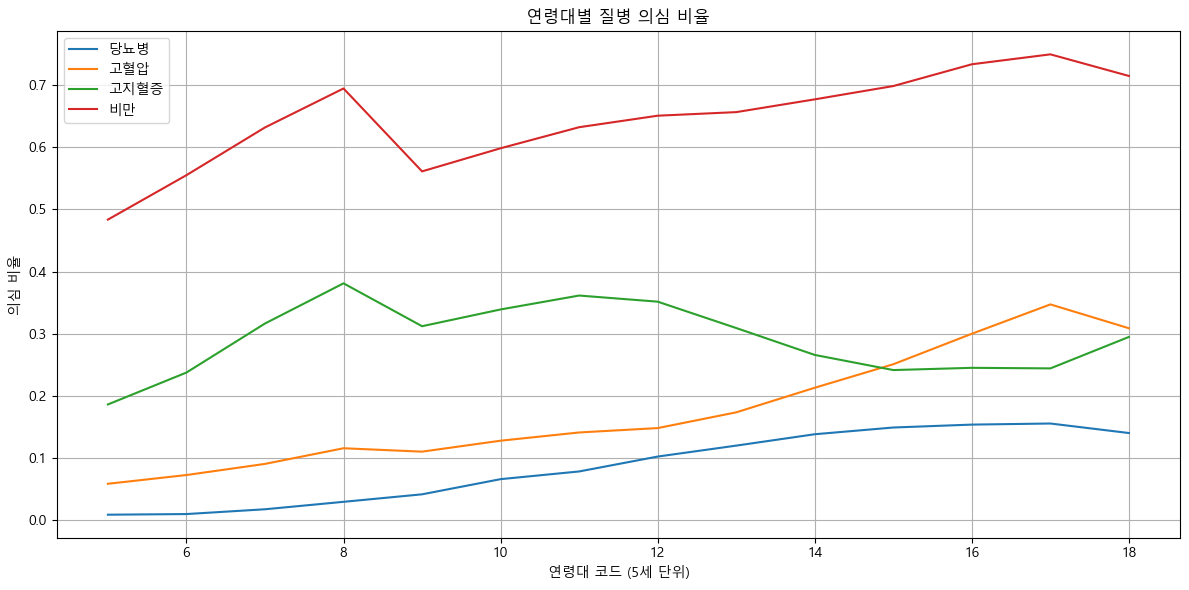

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 파일 불러오기
df = pd.read_csv("./health_with_disease_flags.csv")

# 연령대별 질병 비율 계산
age_group_stats = df.groupby('연령대코드(5세단위)')[['당뇨병의심', '고혈압의심', '고지혈증의심', '비만의심']].mean().reset_index()

# 시각화
plt.figure(figsize=(12, 6))
sns.lineplot(data=age_group_stats, x='연령대코드(5세단위)', y='당뇨병의심', label='당뇨병')
sns.lineplot(data=age_group_stats, x='연령대코드(5세단위)', y='고혈압의심', label='고혈압')
sns.lineplot(data=age_group_stats, x='연령대코드(5세단위)', y='고지혈증의심', label='고지혈증')
sns.lineplot(data=age_group_stats, x='연령대코드(5세단위)', y='비만의심', label='비만')
plt.title("연령대별 질병 의심 비율")
plt.xlabel("연령대 코드 (5세 단위)")
plt.ylabel("의심 비율")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 2. 시도코드별 질병 비율 시각화

<Figure size 1400x600 with 0 Axes>

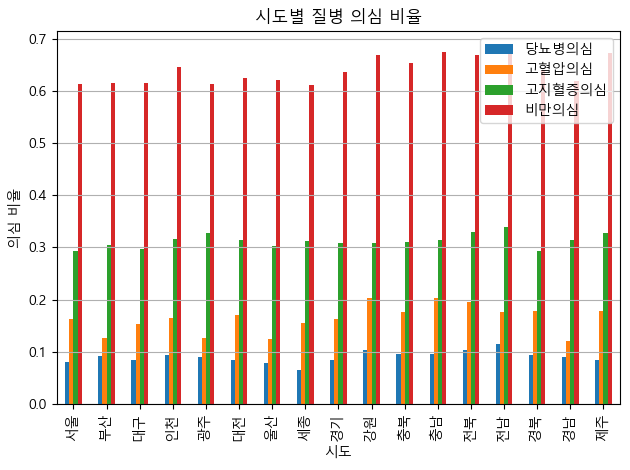

In [6]:
# 시도코드별 질병 비율
region_stats = df.groupby('시도코드')[['당뇨병의심', '고혈압의심', '고지혈증의심', '비만의심']].mean().reset_index()

# 시도코드 → 시도명 매핑
sido_map = {
    11: '서울', 26: '부산', 27: '대구', 28: '인천', 29: '광주',
    30: '대전', 31: '울산', 36: '세종', 41: '경기', 42: '강원',
    43: '충북', 44: '충남', 45: '전북', 46: '전남', 47: '경북',
    48: '경남', 49: '제주'
}
region_stats['시도명'] = region_stats['시도코드'].map(sido_map)

# 시각화
plt.figure(figsize=(14, 6))
region_stats.set_index('시도명')[['당뇨병의심', '고혈압의심', '고지혈증의심', '비만의심']].plot(kind='bar')
plt.title("시도별 질병 의심 비율")
plt.ylabel("의심 비율")
plt.xlabel("시도")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


# 3. 다중 질병 중복자 수 분석

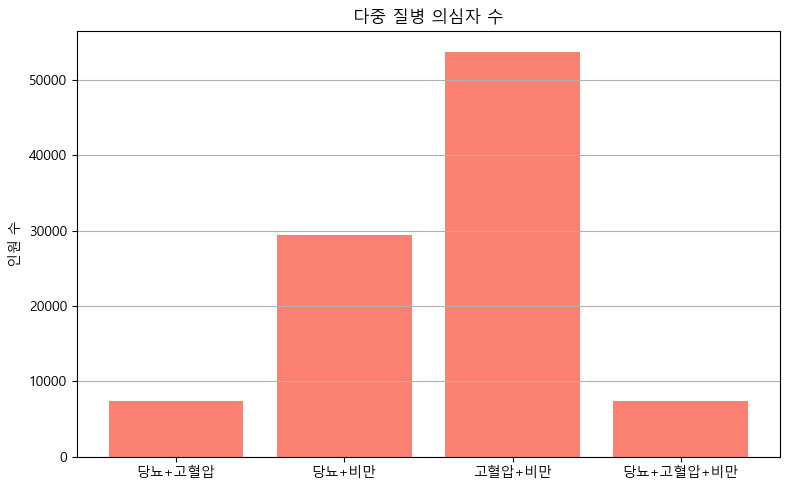

In [7]:
# 당뇨병, 고혈압, 비만 중복자 수 계산
combo_counts = {
    '당뇨+고혈압': df[(df['당뇨병의심'] == 1) & (df['고혈압의심'] == 1)].shape[0],
    '당뇨+비만': df[(df['당뇨병의심'] == 1) & (df['비만의심'] == 1)].shape[0],
    '고혈압+비만': df[(df['고혈압의심'] == 1) & (df['비만의심'] == 1)].shape[0],
    '당뇨+고혈압+비만': df[(df['당뇨병의심'] == 1) & (df['고혈압의심'] == 1) & (df['비만의심'] == 1)].shape[0],
}

# 시각화
plt.figure(figsize=(8, 5))
plt.bar(combo_counts.keys(), combo_counts.values(), color='salmon')
plt.title("다중 질병 의심자 수")
plt.ylabel("인원 수")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 예측 대상: 비만의심
target = '비만의심'

# 사용할 특성 정의
features = [
    '연령대코드(5세단위)', '성별코드', '식전혈당(공복혈당)', '수축기혈압', '이완기혈압',
    '총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤'
]

# 결측치 제거
ml_df = df[features + [target]].dropna()
X = ml_df[features]
y = ml_df[target]

# 학습/테스트 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 학습
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 예측 및 평가
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.72      0.87      0.79     24382
           1       0.91      0.81      0.86     42159

    accuracy                           0.83     66541
   macro avg       0.82      0.84      0.82     66541
weighted avg       0.84      0.83      0.83     66541

